# Integrated cloud-radiative effect vs. cloud cover

We plot the integrated cloud-radiative effect vs. cloud cover.

## Load Standard and User Libraries

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import seaborn as sns
import pylab as pl

In [2]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3
pl.rcParams['axes.labelpad'] = 5
import xarray as xr

In [3]:
import nawdex_analysis.analysis.ave_cre
import nawdex_analysis.io.collector
import nawdex_analysis.plot.legend

from nawdex_analysis.plot.stacked_analysis_plots import vert_stacked_exp_plot, get_exp_kws, get_plotting_order

## Read Radiation Fluxes

This is a slight jump forward in time. Now, average radiation fluxes are available for different CT categories.

In [4]:
rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict' )
suffix = ''
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'all' )

#rset = nawdex_analysis.io.collector.get_radflux4set( 2 )
# suffix = '_set2'


## Convert Flux to CRE (Scaling !!!!)

In [5]:
nawdex_analysis.analysis.ave_cre.radflux2cre( rset, scaling = True, new_factor = 0.88, old_factor = 0.9 )

In [6]:
rset

<xarray.Dataset>
Dimensions:          (ct: 11, idname: 16, time: 264)
Coordinates:
  * idname           (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct               (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
  * time             (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac            (time, ct, idname) float64 22.11 21.22 ... 8.958 8.958
    swf_up_clear     (idname, time, ct) float64 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0
    swf_net_clear    (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_down         (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf_clear        (time, ct, idname) float64 276.2 276.4 ... 272.9 270.9
    swf_up           (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net          (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf              (time, ct, idname) float64 274.5 274.3 ... 255.8 255.8
    expname          (time, idname) object 'naw

In [7]:
idset = 'old'
idset = 'all'

rset.idname.data


# old set 
if idset == 'old':
    rset = rset.sel( idname = ['10km_oneMom_Conv', '10km_twoMom_Conv', '20km_oneMom_Conv',
           '20km_twoMom_Conv', '2km_oneMom_noConv', '2km_twoMom_noConv', '40km_oneMom_Conv',
           '40km_twoMom_Conv', '5km_oneMom_Conv', '5km_twoMom_Conv',
           '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-not_scaled',
           'msevi-scaled'] )
elif idset == 'sh-only':
    rset = rset.sel( idname = ['10km_oneMom_Conv', '10km_twoMom_Conv', '20km_oneMom_Conv',
           '20km_twoMom_Conv', '2km_oneMom_shConv', '2km_twoMom_shConv', '40km_oneMom_Conv',
           '40km_twoMom_Conv', '5km_oneMom_Conv', '5km_twoMom_Conv',
           '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-not_scaled',
           'msevi-scaled'] )

else:
    pass

## Calculate Mean and STD

In [8]:
catlist = list( rset.ct.data )
catlist.remove('clear_ocean')

dset = rset.sel(ct = catlist)

daily_mean = dset.sum('ct').groupby('time.day').mean('time')
# dvar = daily_mean.quantile([0.25, 0.5, 0.75], dim = 'day').diff('quantile')
dvar = daily_mean.std('day')
mvar = daily_mean.mean('day')

dvar_q = ( daily_mean.quantile(0.84, 'day') - daily_mean.quantile(0.16, 'day')  ) /2.

In [9]:
mvar

<xarray.Dataset>
Dimensions:          (idname: 16)
Coordinates:
  * idname           (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
Data variables:
    afrac            (idname) float64 75.84 76.85 74.6 ... 73.83 73.12 73.12
    swf_up_clear     (idname) float64 340.8 340.0 341.1 ... 329.7 341.1 300.2
    swf_net_clear    (idname) float64 -2.181e+03 -2.164e+03 ... -2.2e+03
    swf_down         (idname) float64 -2.521e+03 -2.504e+03 ... -2.501e+03
    lwf_clear        (idname) float64 2.374e+03 2.366e+03 ... 2.346e+03
    swf_up           (idname) float64 845.1 883.1 842.7 ... 799.6 898.2 898.2
    swf_net          (idname) float64 -1.676e+03 -1.62e+03 ... -1.602e+03
    lwf              (idname) float64 2.028e+03 2.004e+03 ... 1.895e+03
    fnet             (idname) float64 352.0 384.0 350.6 ... 340.5 293.0 293.0
    fnet_clear       (idname) float64 193.3 202.3 193.9 ... 165.6 204.2 145.3
    scre_ave         (idname) float64 -504.3 -543.1 -501.6 ... -557.1 -598.0
    lcre_ave 

## Plotting

In [10]:
def errplot_ave_vars( mvar, dvar, vname1, vname2 ):
    
    vlist = list( mvar['idname'].data )
    order = get_plotting_order( vlist )
    
    for idname in np.array( vlist )[order]:
    
    
        label = idname
        
        d = mvar.sel(idname = idname)
        do = mvar.sel(idname = 'msevi-scaled' )
    
        derr = dvar.sel(idname = idname)
    
    
        kws = get_exp_kws( idname, ptype = 'points' )
        pl.plot( d[vname1], d[vname2], label = idname, **kws)

        kws = get_exp_kws( idname, ptype = 'lines' )
        pl.errorbar( d[vname1], d[vname2], xerr = derr[vname1], label = None, yerr = derr[vname2], **kws)
    
        #pl.plot( [do[vname1], d[vname1]], 
        #         [do[vname2], d[vname2]], color='gray', alpha = 0.3, lw = 2)
        
    return
    

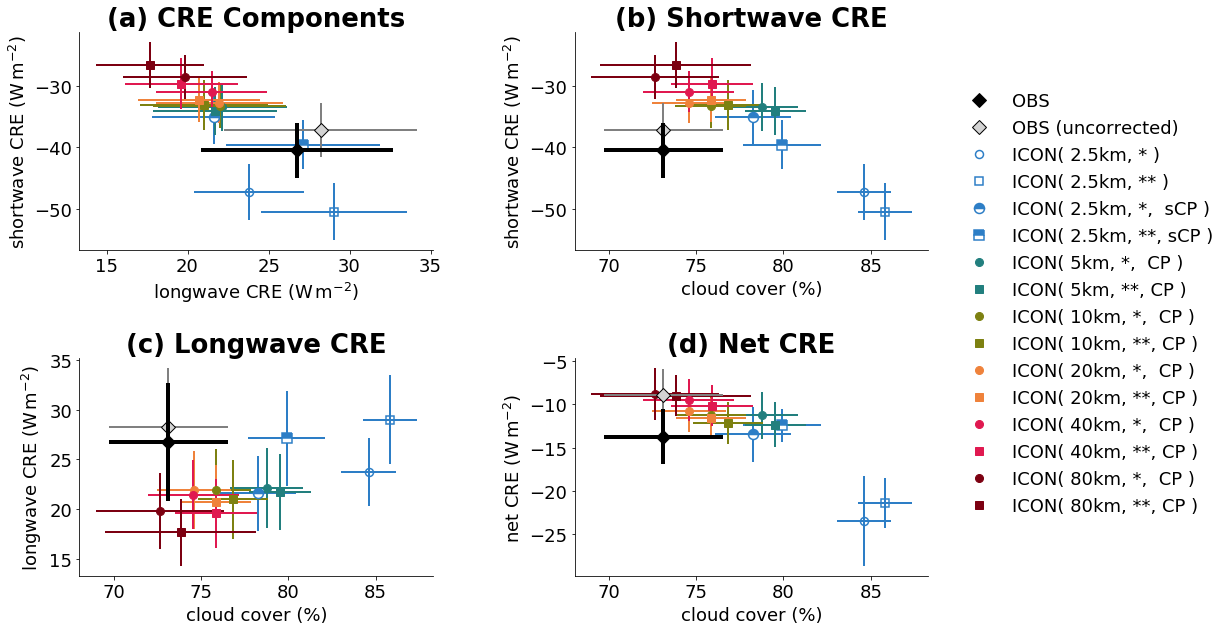

In [11]:
fig, ax = pl.subplots( ncols = 2, nrows = 2, figsize = (18,10))
ax = ax.flatten()
pl.subplots_adjust( hspace = 0.5, right = 0.78, wspace = 0.4)

pl.sca(ax[0])

errplot_ave_vars(mvar, dvar_q, 'lcre_contrib', 'scre_contrib')

pl.xlabel( 'longwave CRE ($\mathrm{W\, m^{-2}}$)')
pl.ylabel( 'shortwave CRE ($\mathrm{W\, m^{-2}}$)')
sns.despine()
#pl.legend( loc = 'center right', bbox_to_anchor=(2.1, 0.5), ncol = 2 )
pl.title('(a) CRE Components', fontweight = 'bold', fontsize = 'x-large')



pl.sca(ax[1])
errplot_ave_vars(mvar, dvar_q, 'afrac', 'scre_contrib')

pl.xlabel( 'cloud cover (%)')
pl.ylabel( 'shortwave CRE ($\mathrm{W\, m^{-2}}$)')
sns.despine()
#pl.legend( loc = 'center right', bbox_to_anchor=(2.1, 0.5), ncol = 2 )
pl.title('(b) Shortwave CRE', fontweight = 'bold', fontsize = 'x-large')
nawdex_analysis.plot.legend.plegend(loc = 'upper right', fontsize = 'medium', 
                                    bbox_to_anchor = (1.85, 0.8) )

pl.sca(ax[2])
errplot_ave_vars(mvar, dvar_q, 'afrac', 'lcre_contrib')

pl.xlabel( 'cloud cover (%)')
pl.ylabel( 'longwave CRE ($\mathrm{W\, m^{-2}}$)')
sns.despine()
#pl.legend( loc = 'center right', bbox_to_anchor=(2.1, 0.5), ncol = 2 )
pl.title('(c) Longwave CRE', fontweight = 'bold', fontsize = 'x-large')


pl.sca(ax[3])
errplot_ave_vars(mvar, dvar_q, 'afrac', 'net_cre_contrib')

pl.xlabel( 'cloud cover (%)')
pl.ylabel( 'net CRE ($\mathrm{W\, m^{-2}}$)')
sns.despine( )
#pl.legend( loc = 'center right', bbox_to_anchor=(2.1, 0.5), ncol = 2 )
pl.title('(d) Net CRE', fontweight = 'bold', fontsize = 'x-large')
pl.savefig('../pics/domain_average_cre_components_cc%s.png' % suffix, dpi = 300)

## Plotting the Cess Ratio (see Stephens (2005), p.243)

The ratio is e.g. stated in Stephens (2005). Using his nomenclature, it is defined as

$$
r = -\frac{C_\mathrm{SW}}{C_\mathrm{LW}}
$$

from Cess et al. (2001).

__References__
  
Cess et al. (2001) The influence of the 1998 El Niño upon cloud-radiative forcing over the Pacific warm pool. J. Climate, 14, 2129–2137.
    
Stephens, G. L. (2005), Cloud Feedbacks in the Climate System: A Critical Review, J. Climate, 18(2), 237–273, doi:10.1175/JCLI-3243.1.
  
  

In [12]:
dset = rset.sel(ct = catlist)
daily = dset.sum('ct').groupby('time.day').mean('time')

daily['r'] = - daily['scre_contrib'] / daily['lcre_contrib']

mvar = daily.mean('day')
dvar = daily.std('day')


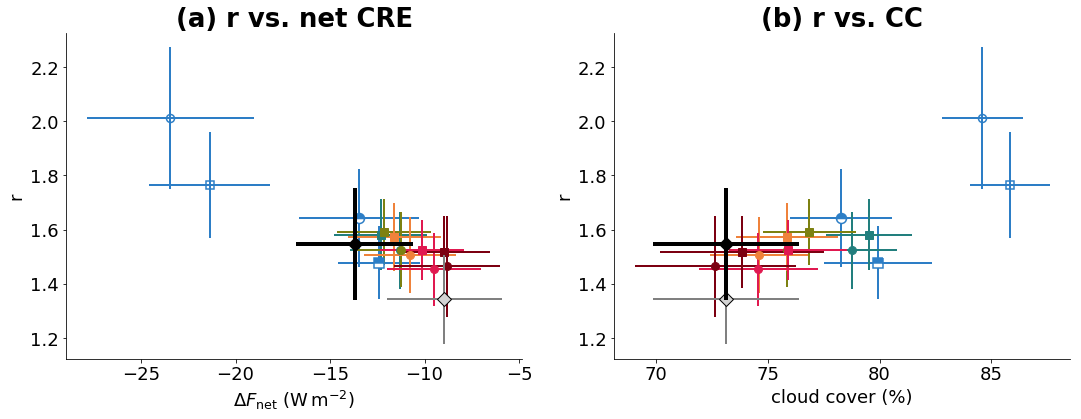

In [13]:
fig, ax = pl.subplots( ncols = 2, nrows = 1, figsize = (18,6))
ax = ax.flatten()

pl.sca(ax[0])

errplot_ave_vars(mvar, dvar, 'net_cre_contrib', 'r')

pl.xlabel( '$\Delta F_\mathrm{net}$ ($\mathrm{W\, m^{-2}}$)')
pl.ylabel('r')

sns.despine()
#pl.legend( loc = 'center right', bbox_to_anchor=(2.1, 0.5), ncol = 2 )
pl.title('(a) r vs. net CRE', fontweight = 'bold', fontsize = 'x-large')



pl.sca(ax[1])
errplot_ave_vars(mvar, dvar, 'afrac', 'r')

pl.xlabel( 'cloud cover (%)')
pl.ylabel('r')
sns.despine()
#pl.legend( loc = 'center right', bbox_to_anchor=(2.1, 0.5), ncol = 2 )
pl.title('(b) r vs. CC', fontweight = 'bold', fontsize = 'x-large')
pl.savefig('../pics/domain_average_cess-ratio%s.png' % suffix, dpi = 300)

In [14]:
mvar['r'].to_dataframe()

,r
idname,
10km_oneMom_Conv,1.526249
10km_twoMom_Conv,1.589450
20km_oneMom_Conv,1.505814
20km_twoMom_Conv,1.572983
2km_oneMom_noConv,2.011268
2km_oneMom_shConv,1.641882
2km_twoMom_noConv,1.763433
2km_twoMom_shConv,1.478486
40km_oneMom_Conv,1.453055


In [15]:
r_ref = mvar['r'].sel(idname = 'msevi-scaled')
dr = (100 * (mvar['r'] - r_ref ) / r_ref ).to_dataframe()
dr

,r
idname,
10km_oneMom_Conv,-1.342380
10km_twoMom_Conv,2.742932
20km_oneMom_Conv,-2.663364
20km_twoMom_Conv,1.678527
2km_oneMom_noConv,30.009470
2km_oneMom_shConv,6.132168
2km_twoMom_noConv,13.989267
2km_twoMom_shConv,-4.429807
40km_oneMom_Conv,-6.073698


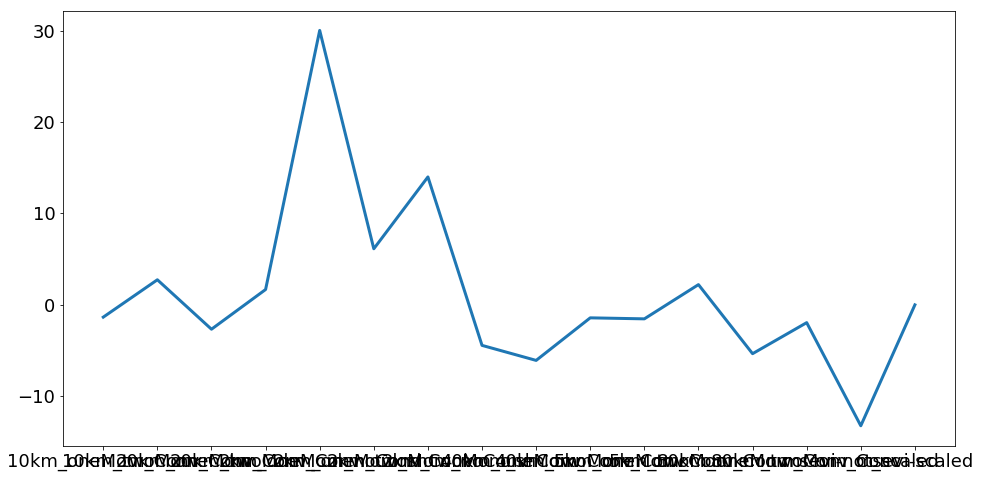

In [16]:
pl.plot(dr)